In [1]:
from utils import config, sample_utils as su, parse_midas_data
from collections import defaultdict
import numpy as np, math
from matplotlib import pyplot as plt
import bz2

In [2]:
sample_subject_map = su.parse_sample_subject_map()
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')
infant_samples = [sample for sample in infant_samples if sample not in olm_samples]
samples = su.get_sample_names('backhed')
good_species_list = parse_midas_data.load_pickled_good_species_list()

In [3]:
# Load alpha diversity, richness at different timepoints

# Relative abundance file
relab_fpath = "%s/species/relative_abundance.txt.bz2" % (config.data_directory)
relab_file = open(relab_fpath, 'r')
decompressor = bz2.BZ2Decompressor()
raw = decompressor.decompress(relab_file.read())
data = [row.split('\t') for row in raw.split('\n')]
data.pop() # Get rid of extra element due to terminal newline
header = su.parse_merged_sample_names(data[0])

# Generate alpha diversity dictionary
alpha_div_dict = {}
richness_dict = {}
relab_dict = defaultdict(dict) # sample -> species -> relab

for i in range(1, len(header)):
    
    sample = header[i]
    for row in data[1:]:
        species = row[0]
        rel_ab = float(row[i])
        if rel_ab > 0:
            relab_dict[sample][species] = rel_ab
    
    acc = 0
    richness = 0
    for row in data[1:]:
        rel_ab = float(row[i])
        if rel_ab != 0:
            acc += (rel_ab * math.log(rel_ab))
            richness += 1
    alpha_div_dict[header[i]] = (acc*-1)
    richness_dict[header[i]] = richness

In [4]:
subjects = set([sample_subject_map[sample][:-2] for sample in samples])

backhed_order_tp_dict = {1: 'Birth', 2: 'Month 4', 3: 'Month 12'}

# Reformat into subject -> tp -> alpha diversity
subject_tp_alpha_div = {subject: defaultdict(dict) for subject in subjects}

for sample in samples:
    
    subject, mi_type = sample_subject_map[sample].split('-')
    order = sample_order_map[sample][1]
    if mi_type == 'M':
        tp = 'Mother'
    elif mi_type == 'I':
        tp = backhed_order_tp_dict[order]
    
    subject_tp_alpha_div[subject][tp] = alpha_div_dict[sample]

In [5]:
# Load data from Ricky
data_dir = config.data_directory
f = open('%s/strains/Backhed_2015_strain_number.csv' % data_dir, 'r')
f.readline()

all_species = set()
sample_species_strain_count = defaultdict(dict)
possible_counts = set()

for line in f:
    sample, species, count = line.strip().split(',')
    sample_species_strain_count[sample][species] = int(count)
    possible_counts.add(int(count))
    all_species.add(species)

In [6]:
subjects = set([sample_subject_map[sample][:-2] for sample in sample_species_strain_count])

backhed_order_tp_dict = {1: 'Birth', 2: 'Month 4', 3: 'Month 12'}

# Reformat into subject -> species -> tp -> count
subject_tp_strain_count = {subject: defaultdict(dict) for subject in subjects}

# subject -> tp -> strain richness
subject_tp_strain_richness = {subject: {} for subject in subjects}

for sample in sample_species_strain_count:
    
    subject, mi_type = sample_subject_map[sample].split('-')
    order = sample_order_map[sample][1]
    if mi_type == 'M':
        tp = 'Mother'
    elif mi_type == 'I':
        tp = backhed_order_tp_dict[order]
    
    strain_richness = 0
    
    for species in sample_species_strain_count[sample]:
        count = sample_species_strain_count[sample][species]        
        subject_tp_strain_count[subject][species][tp] = count        
        strain_richness += count
    
    subject_tp_strain_richness[subject][tp] = strain_richness

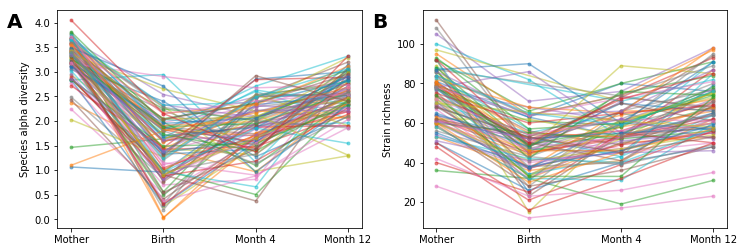

In [7]:
tps_ordered = ['Mother', 'Birth', 'Month 4', 'Month 12']
tp_x_dict = {'Mother': 0, 'Birth': 1, 'Month 4': 2, 'Month 12': 3}
xs = np.arange(len(tps_ordered))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for subject in subject_tp_alpha_div:
    alpha_divs = []
    xs_subset = []
    for tp in tps_ordered:
        if tp in subject_tp_alpha_div[subject]:
            alpha_divs.append(subject_tp_alpha_div[subject][tp])
            xs_subset.append(tp_x_dict[tp])
    ax[0].plot(xs_subset, alpha_divs, '.-', alpha=0.5)

ax[0].set_ylabel("Species alpha diversity")
ax[0].set_xticks(xs)
ax[0].set_xticklabels(tps_ordered)
ax[0].text(-0.165, 0.92, 'A', size=20, transform=ax[0].transAxes, weight='bold')

for subject in subject_tp_strain_richness:
    richnesses = []
    xs_subset = []
    for tp in tps_ordered:
        if tp in subject_tp_strain_richness[subject]:
            richnesses.append(subject_tp_strain_richness[subject][tp])
            xs_subset.append(tp_x_dict[tp])
    ax[1].plot(xs_subset, richnesses, '.-', alpha=0.5)

ax[1].set_ylabel("Strain richness")
ax[1].set_xticks(xs)
ax[1].set_xticklabels(tps_ordered)
ax[1].text(-0.165, 0.92, 'B', size=20, transform=ax[1].transAxes, weight='bold')
plt.show()

fig.savefig('%s/backhed_strain_richness.pdf' % config.analysis_directory)

Mother
98
Birth
98
Month 4
98
Month 12
98


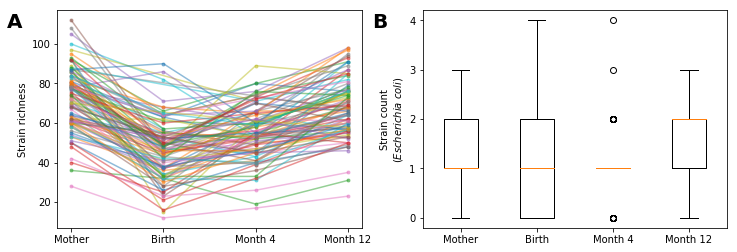

In [8]:
# Version 2
tps_ordered = ['Mother', 'Birth', 'Month 4', 'Month 12']
tp_x_dict = {'Mother': 0, 'Birth': 1, 'Month 4': 2, 'Month 12': 3}
xs = np.arange(len(tps_ordered))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for subject in subject_tp_strain_richness:
    richnesses = []
    xs_subset = []
    for tp in tps_ordered:
        if tp in subject_tp_strain_richness[subject]:
            richnesses.append(subject_tp_strain_richness[subject][tp])
            xs_subset.append(tp_x_dict[tp])
    ax[0].plot(xs_subset, richnesses, '.-', alpha=0.5)

ax[0].set_ylabel("Strain richness")
ax[0].set_xticks(xs)
ax[0].set_xticklabels(tps_ordered)
ax[0].text(-0.165, 0.92, 'A', size=20, transform=ax[0].transAxes, weight='bold')

# E. coli boxplot

tps_ordered = ['Mother', 'Birth', 'Month 4', 'Month 12']
xs = np.arange(len(tps_ordered))

species = 'Escherichia_coli_58110'
tp_count_dict = defaultdict(list)

for subject in subject_tp_strain_count:
    for tp in tps_ordered:
        if tp in subject_tp_strain_count[subject][species]:
            tp_count_dict[tp].append(subject_tp_strain_count[subject][species][tp])
        else:
            tp_count_dict[tp].append(0)

counts = [tp_count_dict[tp] for tp in tps_ordered]

for tp in tps_ordered:
    print(tp)
    print(len(tp_count_dict[tp]))

ax[1].boxplot(counts)
ax[1].text(-0.165, 0.92, 'B', size=20, transform=ax[1].transAxes, weight='bold')

ax[1].set_ylabel("Strain count\n" + r'($\it{Escherichia}$ $\it{coli}$)')
ax[1].set_yticks([0,1,2,3,4])
ax[1].set_xticks(xs + 1)
ax[1].set_xticklabels(tps_ordered)
plt.show()

fig.savefig('%s/backhed_strain_richness_v2.pdf' % config.analysis_directory)

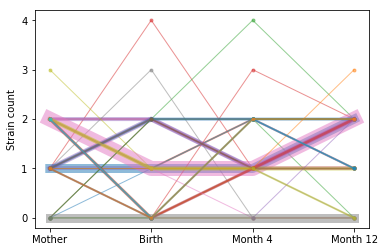

In [8]:
# Idea: have thickness of line be proportionate to number of instances

tps_ordered = ['Mother', 'Birth', 'Month 4', 'Month 12']
xs = np.arange(len(tps_ordered))

species = 'Escherichia_coli_58110'

fig, ax = plt.subplots()

counts_count_dict = defaultdict(int)

for subject in subject_tp_strain_count:
    counts = []
    for tp in tps_ordered:
        if tp in subject_tp_strain_count[subject][species]:
            counts.append(subject_tp_strain_count[subject][species][tp])
        else:
            counts.append(0)
    counts_count_dict[tuple(counts)] += 1

for counts in counts_count_dict:
    ax.plot(xs, counts, '.-', linewidth=counts_count_dict[counts], alpha=0.5)

ax.set_ylabel("Strain count")
ax.set_yticks([0,1,2,3,4])
ax.set_xticks(xs)
ax.set_xticklabels(tps_ordered)
plt.show()

Mother
98
1.316326530612245
Birth
98
1.0204081632653061
Month 4
98
1.1326530612244898
Month 12
98
1.4387755102040816


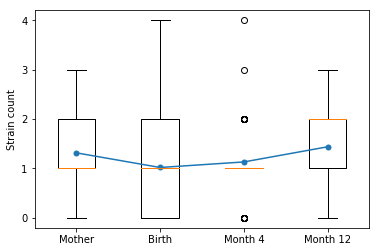

In [14]:
# E. coli boxplot

tps_ordered = ['Mother', 'Birth', 'Month 4', 'Month 12']
xs = np.arange(len(tps_ordered))

species = 'Escherichia_coli_58110'

fig, ax = plt.subplots()

tp_count_dict = defaultdict(list)

for subject in subject_tp_strain_count:
    for tp in tps_ordered:
        if tp in subject_tp_strain_count[subject][species]:
            tp_count_dict[tp].append(subject_tp_strain_count[subject][species][tp])
        else:
            tp_count_dict[tp].append(0)

counts = [tp_count_dict[tp] for tp in tps_ordered]
means = [np.mean(tp_count_dict[tp]) for tp in tps_ordered]

for tp in tps_ordered:
    print(tp)
    print(len(tp_count_dict[tp]))
    print(np.mean(tp_count_dict[tp]))

ax.boxplot(counts)
ax.plot(xs + 1, means, '.-', markersize=10)

ax.set_ylabel("Strain count")
ax.set_yticks([0,1,2,3,4])
ax.set_xticks(xs + 1)
ax.set_xticklabels(tps_ordered)
plt.show()

In [17]:
# Load pickles
import pickle
# Pickle directory
pickle_dir = "%s/pickles" % config.data_directory
sample_species_polymorphism_dict = pickle.load(open("%s/sample_species_polymorphism_dict.pkl" % (pickle_dir), 'rb'))

In [20]:
# How does strain number relate to polymorphism rate?

species = 'Escherichia_coli_58110'

polymorphisms = []
strain_counts = []

for sample in sample_species_strain_count:
    if species in sample_species_polymorphism_dict[sample] and species in sample_species_strain_count[sample]:
        polymorphism = sample_species_polymorphism_dict[sample][species]
        strain_count = sample_species_strain_count[sample][species]
        polymorphisms.append(polymorphism)
        strain_counts.append(strain_count)

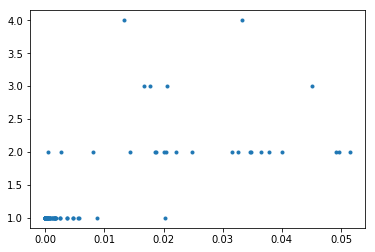

In [23]:
plt.plot(polymorphisms, strain_counts, '.')
plt.show()

In [21]:
backhed_tp_day_dict = {'Birth': 3, 'Mother': 2, 'Month 4': 122, 'Month 12': 366}

In [24]:
# Generate table for processing with R, specifically
# Fit linear model: 
# Num strains E. coli ~ time + host (random effect)

species = 'Escherichia_coli_58110'

output_file = open('%s/%s_strain_data.csv' % (config.analysis_directory, species), 'wb')
output_file.write(','.join(['num_strains', 'time', 'host']) + '\n')

for subject in subject_tp_strain_count:
    for tp in tps_ordered:
        if tp in subject_tp_strain_count[subject][species]:
            day = backhed_tp_day_dict[tp]
            output_file.write(','.join([str(v) for v in [subject_tp_strain_count[subject][species][tp], day, subject]]) + '\n')
        else:
            output_file.write(','.join([str(v) for v in [0, day, subject]]) + '\n')

output_file.close()

In [76]:
# Find most prevalent species among infants

species_nonzero_count = defaultdict(int)
species_relabs = defaultdict(list)

for sample in infant_samples:
    for species in relab_dict[sample]:
        species_relabs[species].append(relab_dict[sample][species])
        if relab_dict[sample][species] > 0:
            species_nonzero_count[species] += 1

species_infant_prev_ordered = []
for species, count in sorted(species_nonzero_count.items(), key=lambda x: x[1], reverse=True):
    species_infant_prev_ordered.append(species)

species_avg_relabs = {species: np.mean(species_relabs[species]) for species in species_relabs}

species_infant_relab_ordered = []
for species, avg_relab in sorted(species_avg_relabs.items(), key=lambda x: x[1], reverse=True):
    species_infant_relab_ordered.append(species)

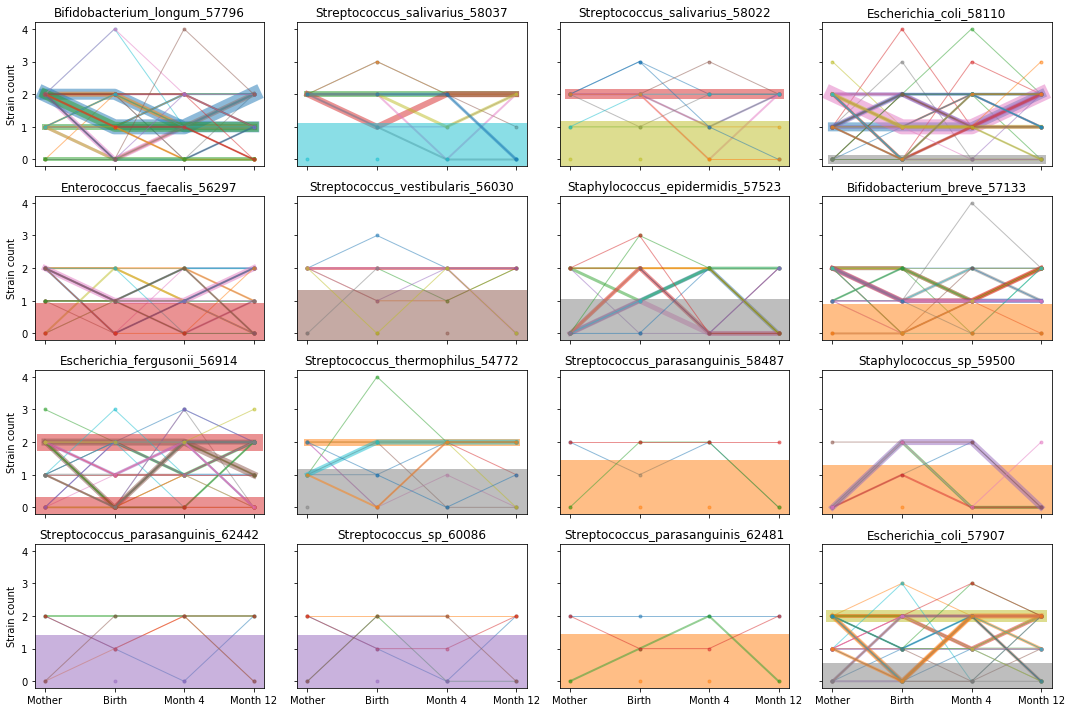

In [85]:
# Idea: have thickness of line be proportionate to number of instances

tps_ordered = ['Mother', 'Birth', 'Month 4', 'Month 12']
xs = np.arange(len(tps_ordered))

idx_matrix = np.transpose(np.meshgrid(np.arange(4), np.arange(4)))
idx_pairs = []
for row in idx_matrix:
    idx_pairs += list(row)

fig, ax = plt.subplots(4, 4, figsize=(15, 10), sharey=True, sharex=True)

for species, idx_pair in zip(species_infant_prev_ordered[:16], idx_pairs):
    i, j = idx_pair
    
    counts_count_dict = defaultdict(int)

    for subject in subject_tp_strain_count:
        counts = []
        for tp in tps_ordered:
            if tp in subject_tp_strain_count[subject][species]:
                counts.append(subject_tp_strain_count[subject][species][tp])
            else:
                counts.append(0)
        counts_count_dict[tuple(counts)] += 1

    for counts in counts_count_dict:
        ax[i][j].plot(xs, counts, '.-', linewidth=counts_count_dict[counts], alpha=0.5)
    
    ax[i][j].set_title(species)
    ax[i][0].set_ylabel("Strain count")


ax[0][0].set_yticks([0,1,2,3,4])
ax[0][0].set_xticks(xs)
ax[0][0].set_xticklabels(tps_ordered)

plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.show()
fig.savefig('%s/backhed_strain_count_by_species.pdf' % config.analysis_directory)